In [2]:
# default_exp basic_stats

# Basic Statistics
> Ported Think Stat's `survey.py` script

In [3]:
#hide
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
#export
from thinkstats import nsfg
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
#hide
mpl.style.use("bmh")

In [6]:
dct = nsfg.get_dct_dataframe(nsfg.data_dir/nsfg.dct_file)
dct.head()

,start,vtype,name,fstring,desc,end
0,1,str,caseid,%12s,RESPONDENT ID NUMBER,13
1,13,int,pregordr,%2f,PREGNANCY ORDER (NUMBER),15
2,15,int,howpreg_n,%2f,BB-2 # OF WEEKS OR MONTHS CURRENTLY PREGNANT,17
3,17,int,howpreg_p,%1f,BB-2 CURRENT PREGNANCY LENGTH REPORTED IN MONT...,18
4,18,int,moscurrp,%1f,NUMBER OF MONTHS CURRENTLY PREGNANT,19


In [7]:
%%time
dat = nsfg.get_dat_dataframe(nsfg.data_dir/nsfg.dat_file, dct)

Wall time: 2.28 s


In [8]:
df = dat[nsfg.columns_of_interest].copy()

In [9]:
df = nsfg.cleanup(df)

## Effect size

In [10]:
col = "prglngth"
col1 = "birthord"
length_lim = (27, 46)

In [11]:
length_mask = (df[col] >= length_lim[0]) & (df[col]<=length_lim[1])
first_mask = df[col1]==1
other_mask = df[col1]!=1
m, v = df.loc[(first_mask & length_mask) , col].mean(), df.loc[(first_mask & length_mask) , col].var()
mo, vo = df.loc[(other_mask & length_mask) , col].mean(), df.loc[(other_mask & length_mask) , col].var()

In [12]:
m, v, mo, vo

(38.702079049577335, 5.966524469983441, 38.45389490901656, 5.876963865435888)

In [13]:
#export
def effect_size(m1, m2, v1, v2, n1, n2):
    weighted_std = np.sqrt((n1*v1 + n2*v2)/(n1+n2))
    return (m1-m2)/weighted_std

In [14]:
effect_size(m, mo, v, vo, (first_mask & length_mask).sum(), (other_mask & length_mask).sum(),)

0.10200942346625483

## Probability functions

In [15]:
#export
def get_discrete_pmf(samples:np.ndarray):
    "Turns an array of discrete values into a frozen scipy.stats.rv_discrete instance"
    s = pd.Series(data=samples).value_counts(normalize=True)
    return stats.rv_discrete(name="test", values=(s.index, s.values))

In [16]:
x = np.random.choice([1,2,3], p=[.1, .6, .3], size=10)
pmf = get_discrete_pmf(x)
pmf.xk, pmf.pk

(array([2, 3], dtype=int64), array([0.7, 0.3]))

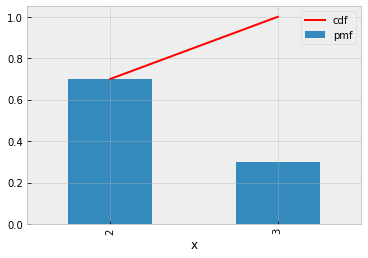

In [17]:
ax = pd.DataFrame({"x":pmf.xk, "p":pmf.pk}).plot(kind="bar", x="x", y="p", label="pmf")
ax.plot(pmf.cdf(pmf.xk), '-r', label="cdf")
ax.legend()

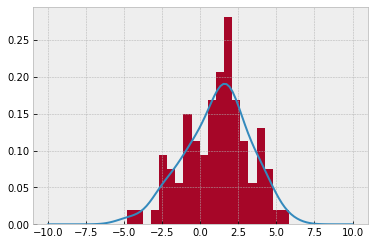

In [18]:
samples = np.random.normal(loc=1., scale=2., size=100)
kde = stats.gaussian_kde(samples)

fig, ax = plt.subplots()
x = np.linspace(-10,10,100)
ax.plot(x, kde.evaluate(x))
ax.hist(samples, bins=20, density=True)
plt.show()

In [19]:
# export
def central_moment(x:np.ndarray, k:int):
    m = x.mean()
    return ((x-m)**k).mean()

def moment(x:np.ndarray, k:int):
    return (x**k).mean()

In [20]:
k = 2
central_moment(x, k=k), moment(x, k=k), stats.norm.moment(k, scale=2, loc=1)

(34.00673400673401, 34.00673400673401, 5.0)

In [21]:
# export
def PearsonsMedianSkewness(x:np.ndarray):
    median = np.median(x)
    mean = np.mean(x)
    std = np.std(x)
    return 3*(mean-median)/std

In [22]:
PearsonsMedianSkewness(x)

-3.655350246359612e-17

## Sampling distributions

Computing and visualizing biased and unbiased statistics over synthesized data.

In [42]:
population_generator = stats.norm(loc=90., scale=5.)  # rv of the population to draw from
sample_size = 9  # number of samples to draw
n_iter = 200  # number of trials drawing `sample_size` samples

Setting up the telemetry storage

In [ ]:
process_telemetry = {
    "mean": np.zeros(n_iter), 
    "std_biased": np.zeros(n_iter), 
    "std_unbiased": np.zeros(n_iter), 
    "sem": np.zeros(n_iter), 
}

Executing `n_iter` trials drawing `sample_size` samples each

In [36]:
%%time
for i in range(n_iter):
    population = population_generator.rvs(size=sample_size)
    process_telemetry["mean"][i] = np.mean(population) 
    process_telemetry["std_biased"][i] = np.std(population)
    process_telemetry["std_unbiased"][i] = np.std(population, ddof=1)
    process_telemetry["sem"][i] = stats.sem(population)

Wall time: 31 ms


Visualizing telemetry in serial form

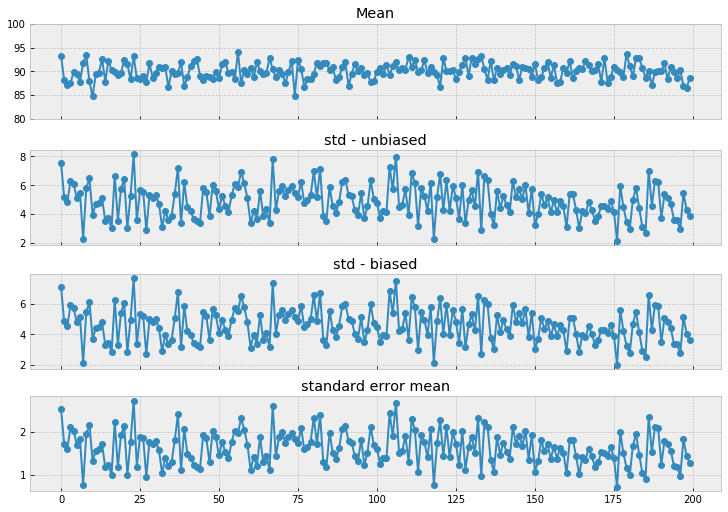

In [37]:
fig, axs = plt.subplots(figsize=(10,7), ncols=1, nrows=4, constrained_layout=True,
                        sharex=True)

ax = axs[0]
ax.plot(process_telemetry["mean"], marker="o")
ax.set_title("Mean")
ax.set_ylim((population_generator.kwds["loc"]-10, population_generator.kwds["loc"]+10))

ax = axs[1]
ax.plot(process_telemetry["std_unbiased"], marker="o")
ax.set_title("std - unbiased")

ax = axs[2]
ax.plot(process_telemetry["std_biased"], marker="o")
ax.set_title("std - biased")

ax = axs[3]
ax.plot(process_telemetry["sem"], marker="o")
ax.set_title("standard error mean")

plt.show()

Visualizing telemetry using distributions

In [39]:
#export
def plot_hist_with_kde(y, left_ext:int=0, right_ext:int=0, fig_params:dict=None, plot_params:dict=None, 
                       ax:mpl.axes._subplots.Axes=None, bins:int=20):
    if ax is None:
        if fig_params is None: fig_params = {}
        fig, ax = plt.subplots(**fig_params)
    ax.hist(y, density=True, bins=bins, alpha=.5)
    kde = stats.gaussian_kde(y)
    x = np.linspace(y.min()-left_ext, y.max()+right_ext, 100)
    ax.plot(x, kde.evaluate(x))
    ax.set(**plot_params)
    return ax

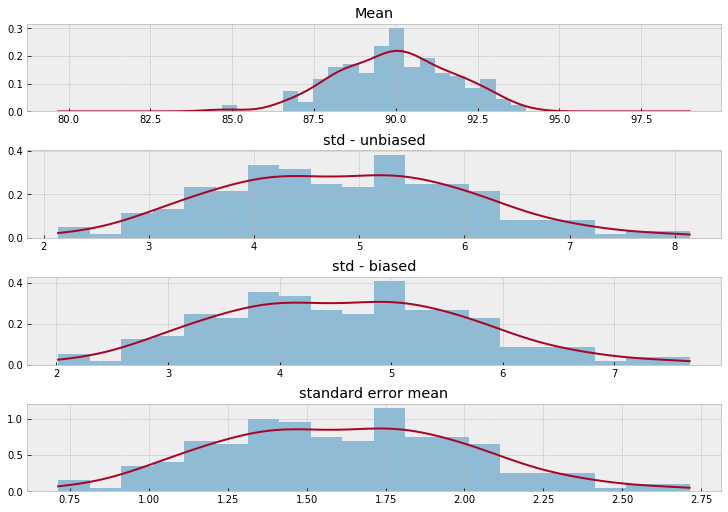

In [40]:
fig, axs = plt.subplots(figsize=(10,7), ncols=1, nrows=4, constrained_layout=True,)
bins = 50

plot_hist_with_kde(process_telemetry["mean"], left_ext=5, right_ext=5, plot_params={"title":"Mean"}, 
                   ax=axs[0])
plot_hist_with_kde(process_telemetry["std_unbiased"], plot_params={"title":"std - unbiased"}, 
                   ax=axs[1])
plot_hist_with_kde(process_telemetry["std_biased"], plot_params={"title":"std - biased"}, 
                   ax=axs[2])
plot_hist_with_kde(process_telemetry["sem"], plot_params={"title":"standard error mean"}, 
                   ax=axs[3])
plt.show()